# Colorizing the Russian Empire

Automatically produce a color image from the digitized Prokudin-Gorskii glass plate images with as few visual artifacts as possible.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_image(fname):
    img = cv2.imread(fname, 0)
    height = int(img.shape[0]/3)
    width = img.shape[1]
    rgb_img = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(3):
        rgb_img[:,:,2-i] = img[height*i:height*(i+1),:]
    return rgb_img, height, width

In [3]:
def get_gradient(im) :
    # Calculate the x and y gradients using Sobel operator
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad

In [9]:
def align_image(rgb_img, height, width, warp_mode, number_of_iterations, termination_eps):
    # Allocate space for aligned image
    im_aligned = np.zeros((height,width,3), dtype=np.uint8 )

    # The blue and green channels will be aligned to the red channel.
    # So copy the red channel
    im_aligned[:,:,0] = rgb_img[:,:,0]

    # Set the warp matrix to identity.
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
            warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
            warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Set the stopping criteria for the algorithm.
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Warp the blue and green channels to the red channel
    for i in range(1,3) :
        (cc, warp_matrix) = cv2.findTransformECC (get_gradient(rgb_img[:,:,0]), get_gradient(rgb_img[:,:,i]),warp_matrix, warp_mode, criteria)

        if warp_mode == cv2.MOTION_HOMOGRAPHY :
            # Use Perspective warp when the transformation is a Homography
            im_aligned[:,:,i] = cv2.warpPerspective (rgb_img[:,:,i], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        else :
            # Use Affine warp when the transformation is not a Homography
            im_aligned[:,:,i] = cv2.warpAffine(rgb_img[:,:,i], warp_matrix, (width, height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
        print(warp_matrix)
    return im_aligned


In [10]:
img, h, w = read_image("./hw2_data/task3_colorizing/emir.tif")

In [11]:
# warp_mode = cv2.MOTION_TRANSLATION
warp_mode = cv2.MOTION_HOMOGRAPHY
number_of_iterations = 5000
termination_eps = 1e-10

In [12]:
result = align_image(img, h, w, warp_mode, number_of_iterations, termination_eps)

[[ 1.0196785e+00  1.0842997e-04 -3.4960802e+00]
 [ 7.5691249e-03  1.0070326e+00  4.6448311e+01]
 [ 4.2798356e-06  4.9686656e-07  1.0000000e+00]]
[[ 1.0476651e+00  1.5065278e-04 -7.9654708e+00]
 [ 2.0598490e-02  1.0235666e+00  6.7093346e+01]
 [ 1.1087107e-05  3.6485309e-07  1.0000000e+00]]


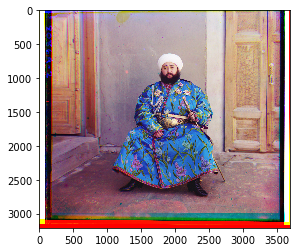

In [13]:
plt.imshow(result)
plt.show()